# 0. Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

In [ ]:
from google.colab import  drive
drive.mount('/content/drive')
POAI_DIRECTORY = '/content/drive/MyDrive/MSC/DND/PoAI'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Download and load dataset

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/MSC/PoAI/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download zahranusrat/students-performance-in-exams

Dataset URL: https://www.kaggle.com/datasets/zahranusrat/students-performance-in-exams
License(s): CC0-1.0
students-performance-in-exams.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q students-performance-in-exams.zip

replace StudentsPerformance (1).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
csv_path = "/content/StudentsPerformance (1).csv"
df = pd.read_csv(csv_path)

In [ ]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


# 2. Exploratory data analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [ ]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


In [ ]:
df.isnull().any()

,0
gender,False
race/ethnicity,False
parental level of education,False
lunch,False
test preparation course,False
math score,False
reading score,False
writing score,False


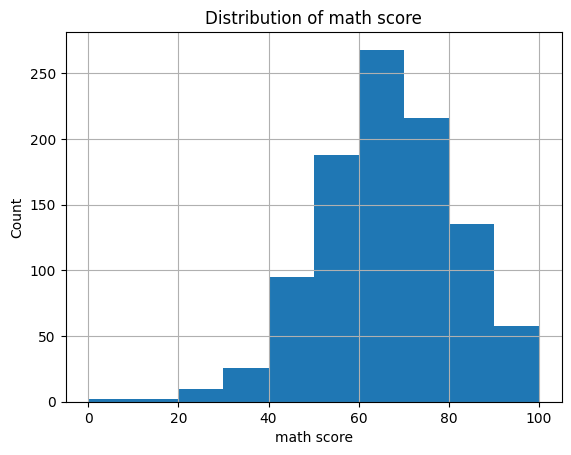

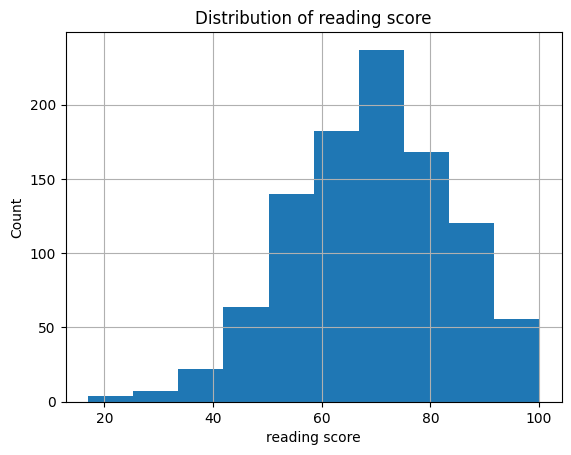

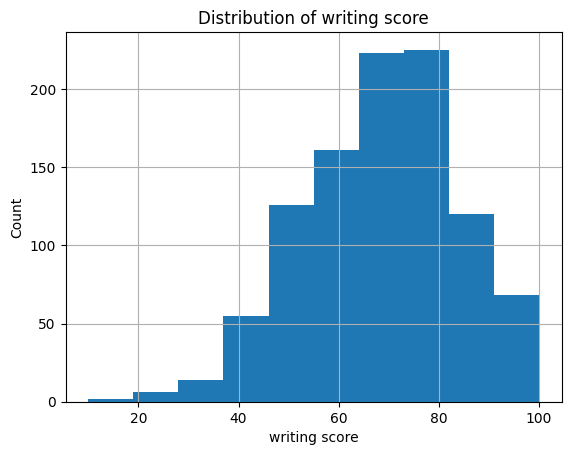

In [ ]:
numeric_cols = ["math score", "reading score", "writing score"]

for col in numeric_cols:
    plt.figure()
    df[col].hist()
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

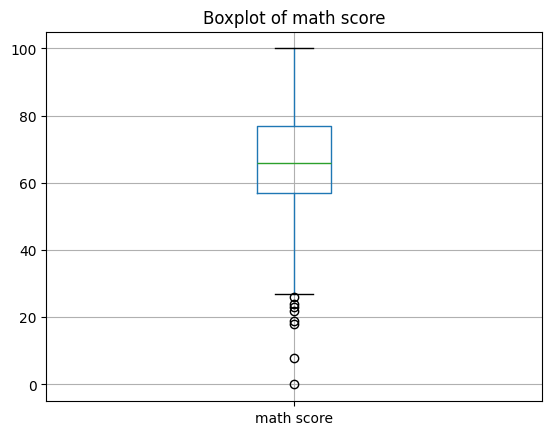

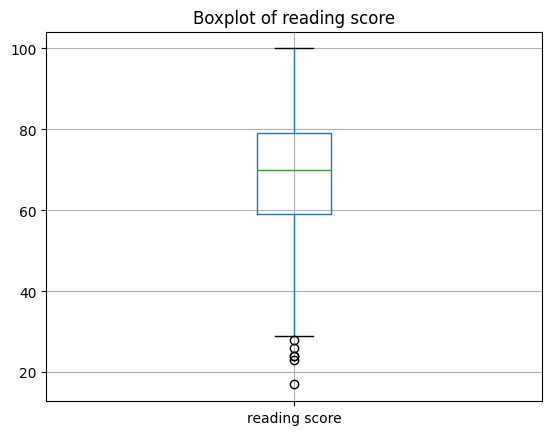

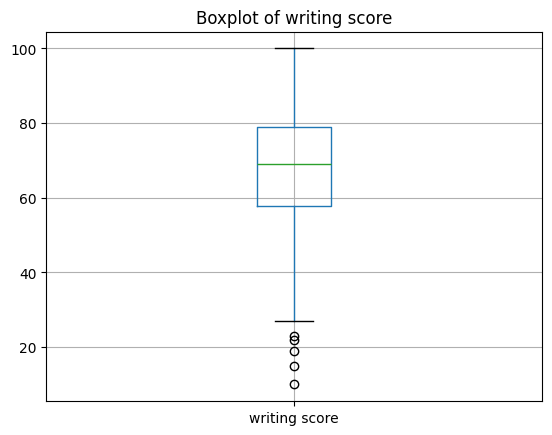

In [ ]:
# checking for outliers

for col in numeric_cols:
    plt.figure()
    df.boxplot(column=col)
    plt.title(f"Boxplot of {col}")
    plt.show()


In [ ]:
df[numeric_cols].agg(["mean", "median", "std", "min", "max"])

,math score,reading score,writing score
mean,66.08900,69.169000,68.054000
median,66.00000,70.000000,69.000000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
max,100.00000,100.000000,100.000000


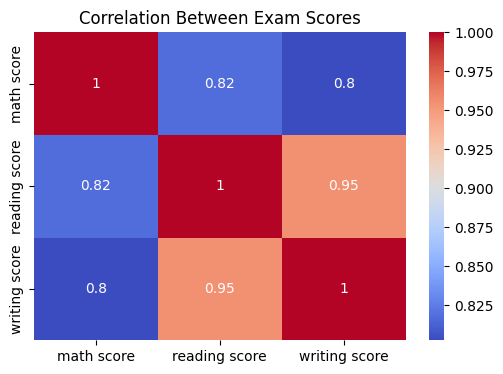

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Exam Scores")
plt.show()

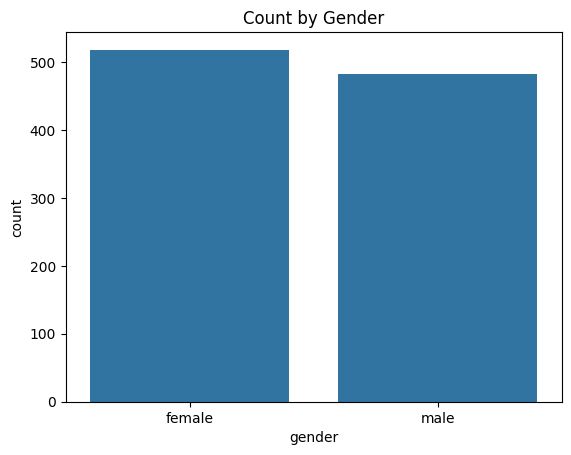

In [ ]:
sns.countplot(data=df, x="gender")
plt.title("Count by Gender")
plt.show()


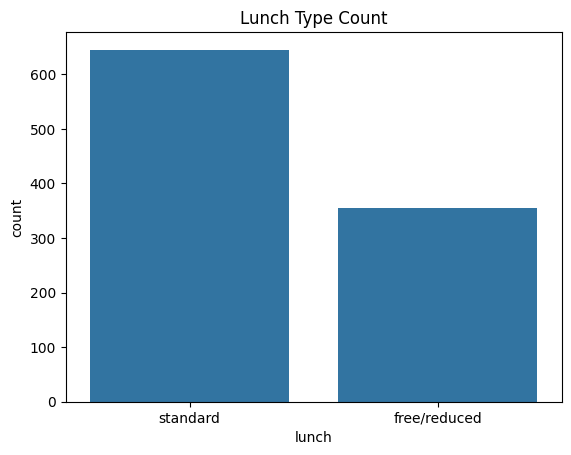

In [ ]:
sns.countplot(data=df, x="lunch")
plt.title("Lunch Type Count")
plt.show()


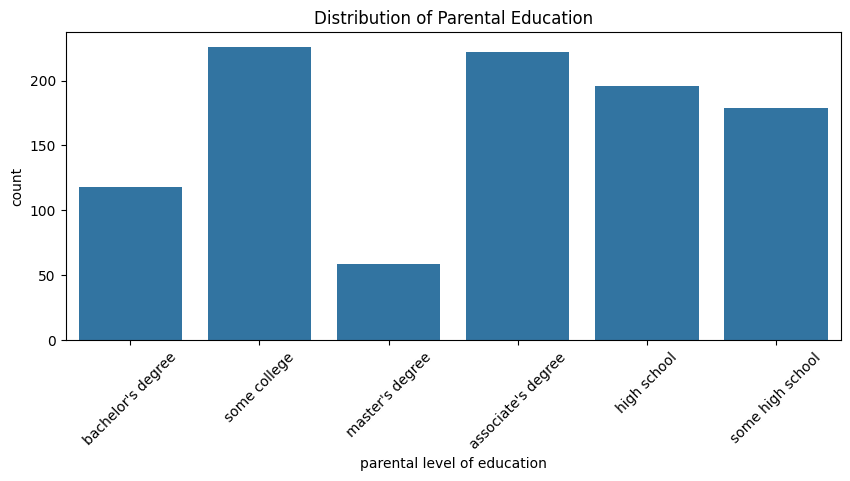

In [ ]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x="parental level of education")
plt.xticks(rotation=45)
plt.title("Distribution of Parental Education")
plt.show()


Counts:
test preparation course
none         642
completed    358
Name: count, dtype: int64

Percentages:
test preparation course
none         64.2
completed    35.8
Name: proportion, dtype: float64


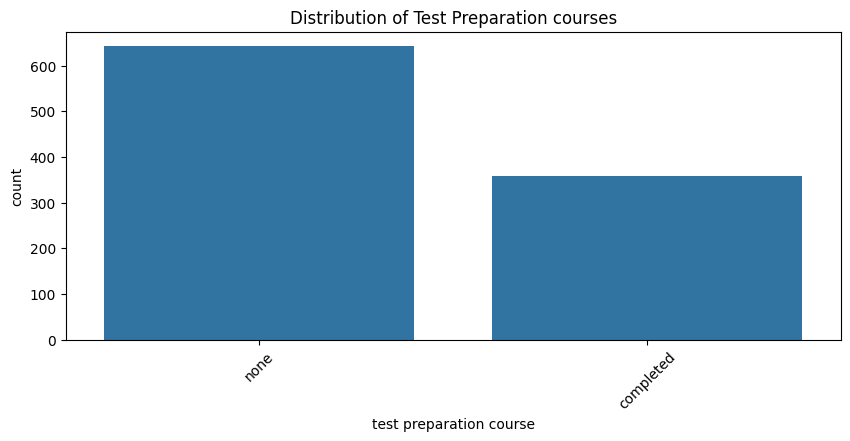

In [ ]:
# Value counts
counts = df["test preparation course"].value_counts()
percentages = df["test preparation course"].value_counts(normalize=True) * 100

print("Counts:")
print(counts)
print("\nPercentages:")
print(percentages.round(2))

plt.figure(figsize=(10,4))
sns.countplot(data=df, x="test preparation course")
plt.xticks(rotation=45)
plt.title("Distribution of Test Preparation courses")
plt.show()

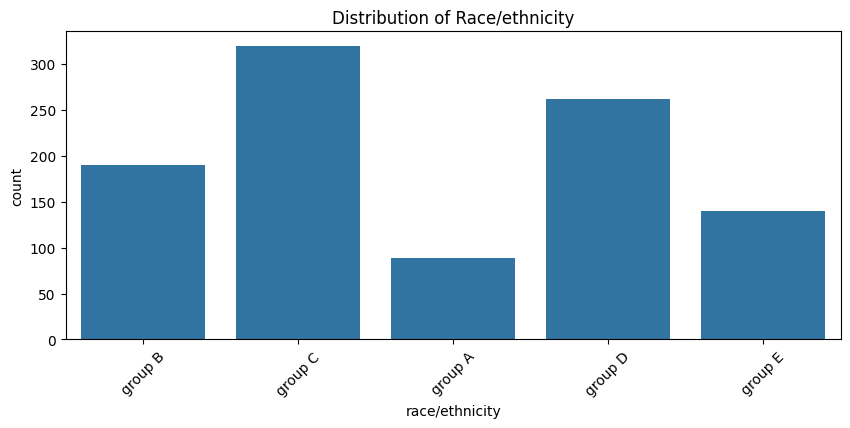

In [ ]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x="race/ethnicity")
plt.xticks(rotation=45)
plt.title("Distribution of Race/ethnicity")
plt.show()

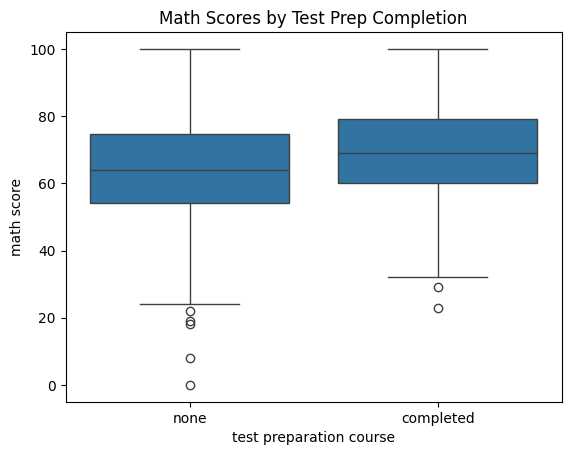

In [ ]:
sns.boxplot(data=df, x="test preparation course", y="math score")
plt.title("Math Scores by Test Prep Completion")
plt.show()


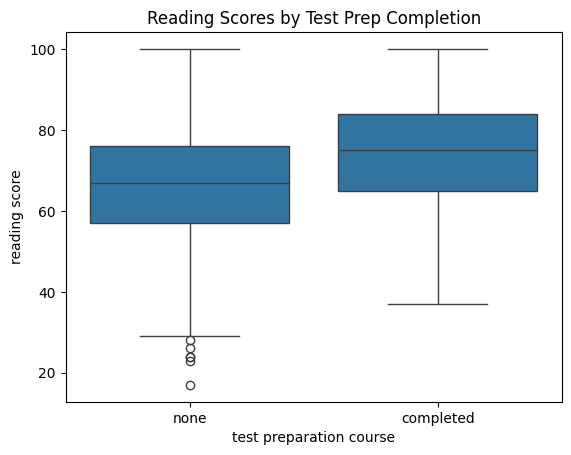

In [ ]:
sns.boxplot(data=df, x="test preparation course", y="reading score")
plt.title("Reading Scores by Test Prep Completion")
plt.show()


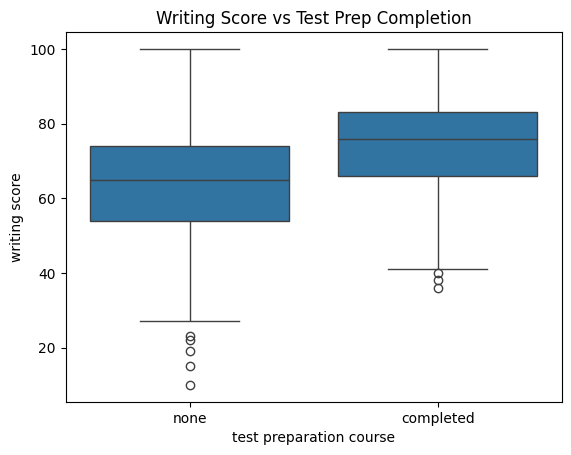

In [ ]:
sns.boxplot(data=df, x="test preparation course", y="writing score")
plt.title("Writing Score vs Test Prep Completion")
plt.show()


# 3. Prepare data for training

In [ ]:
math_scaler = MinMaxScaler()
df["math score"] = math_scaler.fit_transform(df["math score"].values.reshape(-1, 1))

reading_scaler = MinMaxScaler()
df["reading score"] = reading_scaler.fit_transform(df["reading score"].values.reshape(-1, 1))

writing_scaler = MinMaxScaler()
df["writing score"] = writing_scaler.fit_transform(df["writing score"].values.reshape(-1, 1))
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,0.72,0.662651,0.711111
1,female,group C,some college,standard,completed,0.69,0.879518,0.866667
2,female,group B,master's degree,standard,none,0.90,0.939759,0.922222
3,male,group A,associate's degree,free/reduced,none,0.47,0.481928,0.377778
4,male,group C,some college,standard,none,0.76,0.734940,0.722222
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,0.88,0.987952,0.944444
996,male,group C,high school,free/reduced,none,0.62,0.457831,0.500000
997,female,group C,high school,free/reduced,completed,0.59,0.650602,0.611111
998,female,group D,some college,standard,completed,0.68,0.734940,0.744444


In [ ]:
cat_cols = df.select_dtypes(include=["object"]).columns
cat_cols


Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course'],
      dtype='object')

In [ ]:
# Create a label encoder instance
le = LabelEncoder()

# Convert all object columns to numeric codes in-place
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = le.fit_transform(df[col])



In [ ]:
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,1,1,1,1,0.72,0.662651,0.711111
1,0,2,4,1,0,0.69,0.879518,0.866667
2,0,1,3,1,1,0.90,0.939759,0.922222
3,1,0,0,0,1,0.47,0.481928,0.377778
4,1,2,4,1,1,0.76,0.734940,0.722222
...,...,...,...,...,...,...,...,...
995,0,4,3,1,0,0.88,0.987952,0.944444
996,1,2,2,0,1,0.62,0.457831,0.500000
997,0,2,2,0,0,0.59,0.650602,0.611111
998,0,3,4,1,0,0.68,0.734940,0.744444


In [ ]:
y = df['test preparation course']
X = df.drop('test preparation course', axis=1)
print(len(X), len(y))
print(y.value_counts())

1000 1000
test preparation course
1    642
0    358
Name: count, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(800, 7)
(800,)
(200, 7)
(200,)


# 4. Define metrics
## 4.1 Mean Absolute Error
$$
MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|
$$

## 4.2 Root Mean Squared Error
$$
RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_1 - \hat{y_i})^2}
$$

## 4.3 Accuracy
$$
Accuracy = \frac{True\ Positives\ +\ True\ Negatives}{Total\ Predictions}
$$

## 4.4 Confusion Matrix
A table used to evaluate a classification model's performance by comparing predicted versus actual outcomes.

## 4.5 ROC and AUC
### 4.5.1 Receiver Operating Characteristic curve
It is a plot that shows a binary classification model's performance at various threshold settings by plotting the true positive rate against the false positive rate.

### 4.5.2 Area Under the Curve
This is a single scalar value that measures the total area under the ROC curve, representing the probability the the model will rank a randomly chosen positive instance higher than a randomly chosen negative one.

In [ ]:
def get_accuracy(model, X_train, X_test, y_train, y_test, regression=False):
    y_train_pred = model.predict(X_train)

    y_test_pred = model.predict(X_test)

    # MAE
    mae = mean_absolute_error(y_test, y_test_pred)
    print("Mean Absolute Error (MAE): ", mae)

    rmse = root_mean_squared_error(y_test, y_test_pred)
    print("Root Mean Squared error (RMSE): ", rmse)

    if regression:
        return

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)


    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # ROC Curve and AUC
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# 5. Train classification models

## K Nearest Neighbors Classification
A supervised learning technique which takes the **K** nearest samples to a new data point to classify it. **K** is set by the user.

<img src="https://miro.medium.com/1*T8Pnw0kiVbrPGnqnB2I_Zw.jpeg" width="500">


Mean Absolute Error (MAE):  0.415
Root Mean Squared error (RMSE):  0.6442049363362563
Train Accuracy: 0.6925
Test Accuracy: 0.585


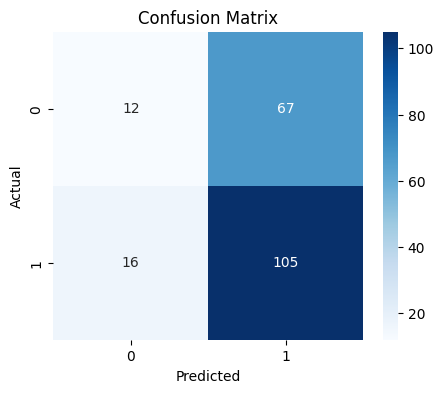

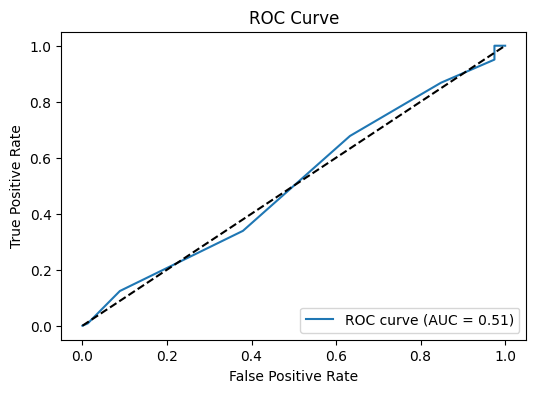

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)

get_accuracy(knn, X_train, X_test, y_train, y_test)

## Logistic Regression

Model coefficients: [[-6.19628421e-01  3.98828161e-02 -6.81449570e-05  4.46334268e-01
   1.05167800e+00 -5.32825340e-01 -4.65559979e+00]]
Intercept: [3.26591394]
Mean Absolute Error (MAE):  0.39
Root Mean Squared error (RMSE):  0.6244997998398398
Train Accuracy: 0.69625
Test Accuracy: 0.61


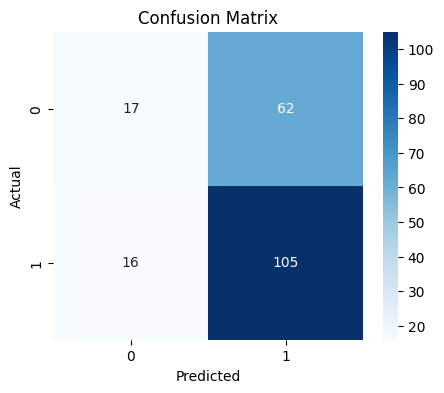

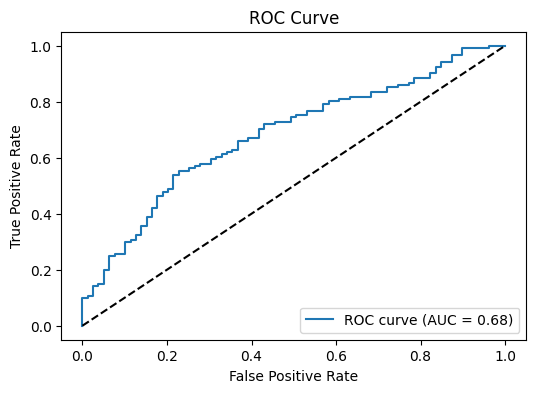

In [ ]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

print("Model coefficients:", log_model.coef_)
print("Intercept:", log_model.intercept_)


get_accuracy(log_model, X_train, X_test, y_train, y_test)

## Decision Tree classifier
A Decision Tree helps us make decisions by showing different options and how they are related. It has a tree-like structure that starts with one main question called the root node which represents the entire dataset. From there, the tree branches out into different possibilities based on features in the data.

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20250626155729954380/Decision-tree-1.webp" width="500px">

(src: https://www.geeksforgeeks.org/machine-learning/decision-tree/)

Mean Absolute Error (MAE):  0.39
Root Mean Squared error (RMSE):  0.6244997998398398
Train Accuracy: 0.76625
Test Accuracy: 0.61


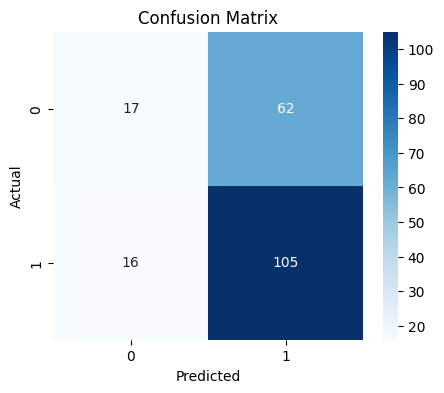

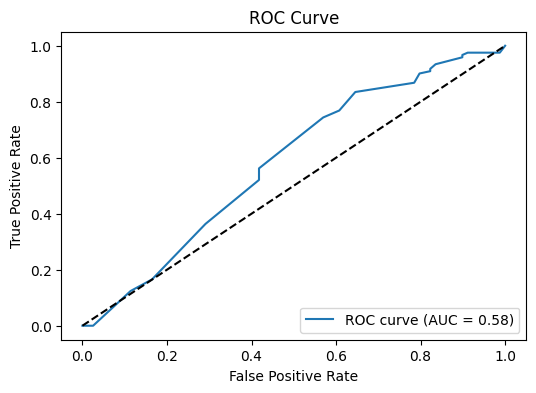

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth=5)
dtree.fit(X_train, y_train)

get_accuracy(dtree, X_train, X_test, y_train, y_test)

## Random Forest classifier
A random forest is a machine learning algorithm that uses an ensemble of multiple decision trees to make more accurate predictions. It improves accuracy by using a technique called bagging, where each tree is trained on a random sample of the data and a random subset of features. For classification, the final prediction is based on a majority vote of all the trees, while for regression, it's based on the average of the individual tree predictions.

Mean Absolute Error (MAE):  0.385
Root Mean Squared error (RMSE):  0.6204836822995429
Train Accuracy: 0.96125
Test Accuracy: 0.615


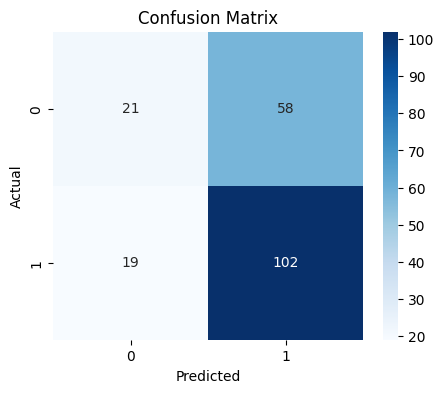

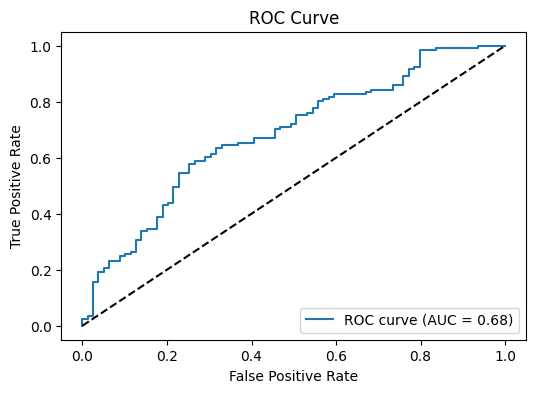

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=80, max_depth=10, random_state=0)
rf.fit(X_train, y_train)
get_accuracy(rf, X_train, X_test, y_train, y_test)

## Gradient boosting
Gradient boosting is a machine learning technique that builds a strong predictive model by sequentially combining multiple weak models, such as decision trees. In each step, a new weak model is trained to correct the errors made by the current ensemble of models, and it is then added to the ensemble to improve overall accuracy. This iterative process minimizes a loss function, making it a powerful method for tasks like regression and classification.



Mean Absolute Error (MAE):  0.29
Root Mean Squared error (RMSE):  0.5385164807134504
Train Accuracy: 0.86375
Test Accuracy: 0.71


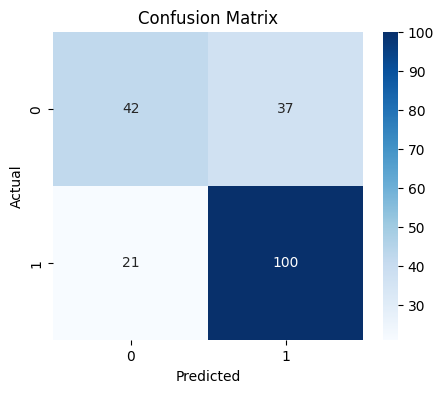

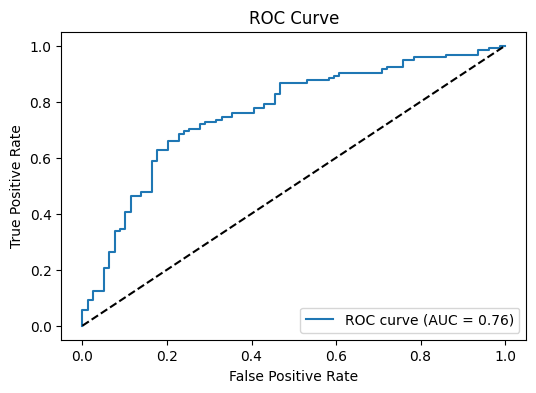

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(max_depth=2, n_estimators=300, learning_rate=0.2)
gbc.fit(X_train, y_train)

get_accuracy(gbc, X_train, X_test, y_train, y_test)

# 6. Train linear models


In [ ]:
y = df['writing score']
X = df.drop('writing score', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Ridge regression
This algorithm addresses some of the problems of ordinary least squares by imposing a penalty on the size of the coefficients. The ridge coefficients minimize a penalized residual sum of squares:
$$
\min\limits_{w}||Xw-y||_2^2 + \alpha||w||_2^2
$$

The complexity parameter $\alpha\ge0$ controls the amount of shrinkage: the larger the value of $\alpha$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity.  

In [ ]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=0.001)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)

print("Model coefficients:", ridge_model.coef_)
print("Intercept:", ridge_model.intercept_)


get_accuracy(ridge_model, X_train, X_test, y_train, y_test, regression=True)

Model coefficients: [-0.06197929  0.00076476 -0.00233633  0.00424176 -0.03655133  0.29506851
  0.63573703]
Intercept: 0.1052351540586457
Mean Absolute Error (MAE):  0.03705006153982222
Root Mean Squared error (RMSE):  0.04525337848860186


## Lasso
Lasso is a linear model that estimates sparse coefficients. It is useful in some contexts due to its tendency to prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent

Mathematically, it consists of a linear model with an added regularization term. The objective function to minimize is:
$$
\min\limits_{w}\frac{1}{2n_{samples}}||Xw-y||_2^2 + \alpha||w||_1
$$

The lasso estimate thus solves the minimization of the least-squares penalty with $\alpha||w||_1$ added, where $\alpha$ is a constant and $||w||_1$ is the $l_1$-norm of the coefficient vector.


In [ ]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train, y_train)

y_pred_lasso = lasso_model.predict(X_test)

print("Model coefficients:", lasso_model.coef_)
print("Intercept:", lasso_model.intercept_)

get_accuracy(lasso_model, X_train, X_test, y_train, y_test, regression=True)

Model coefficients: [-0.05113966  0.00160805 -0.00222059  0.00628493 -0.03416232  0.2118938
  0.66882946]
Intercept: 0.12944044597073778
Mean Absolute Error (MAE):  0.03756223386815498
Root Mean Squared error (RMSE):  0.046395184939364766


## Elastic Net
A linear regression model trained both $l_1$ and $l_2$-norm regularization of the coefficients. This combination allows for learning a sparse model where a few of the weights are non-zero like **Lasso**, while still maintaining the regularization properties of **Ridge**.

The objective goal is to minimize:
$$
\min\limits_{w}\frac{1}{2n_{samples}}||Xw-y||_2^2
+ \alpha\rho||w||_1
+ \frac{1-\rho}{2}||w||_2^2
$$


In [ ]:
from sklearn.linear_model import ElasticNet


elasticnet_model = ElasticNet(alpha=0.0005, l1_ratio=0.1)
elasticnet_model.fit(X_train, y_train)

y_pred_elasticnet = elasticnet_model.predict(X_test)
print("Model coefficients:", elasticnet_model.coef_)
print("Intercept:", elasticnet_model.intercept_)


get_accuracy(elasticnet_model, X_train, X_test, y_train, y_test, regression=True)

Model coefficients: [-0.06434597  0.00082929 -0.00240309  0.0044941  -0.03757515  0.30848768
  0.61285478]
Intercept: 0.11244742322757151
Mean Absolute Error (MAE):  0.03709571046970067
Root Mean Squared error (RMSE):  0.04523743400407967
